<a href="https://www.kaggle.com/code/leesunjjin/ibm-hr-analyst-junior?scriptVersionId=240371654" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# IBM HR Analytics Employee Attrition & Performance

1. 목적 - 직원들의 이직 가능성을 예측하고, 이직 결정에 영향을 미치는 주요 요인을 도출한다. 인적 자원 관리의 효율성을 높이고, 자발적 이직자를 사전 예측에 기여할 수 있다. 

2. 데이터 개요 
* 데이터 출처: IBM HR Analytics Employee Attrition Dataset
* 데이터 구성: 총 1470명의 직원 정보, 35개 컬럼
* 타겟: Attrition(Yes/No)

3. 데이터 전처리
* 고정값만 존재하는 컬럼 제거
* 범주형 변수 > 숫자형 변환 (이진 변수는 0/1로 변환, 라벨인코딩)
* 결측치 없음.

4. 모델링 및 피처 선택 
* 사용 알고리즘: XGBoostClassifier
* 클래스 불균형 대응: scale_pos_weight = 5.2 #8이 가장 적합함을 찾아냄.
* 피처 선택: Recursive Feature Elimination(RFE)사용
  최종 선택 피처 수: 10개 (OverTime, JobSatisfaction, MonthlyIncome, 
EnvironmentSatisfaction, WorkLifeBalance, 
YearsWithCurrManager, BusinessTravel, 
JobRole, MaritalStatus, Age)

5. 예측 성능 평가 
* 교차검증 정확도:86.66%
* 모델 안정성 확보, 과적합 없음
* 이직자 클래스에 대한 recall도 함께 개선됨.

6. SHAP 기반 모델 해석
SHAP(Shapley Additive Explanations)를 활용하여 예측 결과에 대한 피처별 영향도를 시각적으로 분석하였다.

7. 인사이트 도출 
OverTime - 야근 빈도가 높을수록 이직 가능성 증가
JobSatisfaction - 만족도가 낮을수록 이직 가능성 증가
MonthlyIncome - 급여 수준이 낮을수록 이직 가능성 증가
YearWithCurrManager - 상사와의 근속 기간이 짧을수록 이직 가능성 증가
Gender / Department - 상대적으로 영향 미미함.

8. 개선 방안
* 이직 가능성 높은 직원군 선별 > 사전 인터벤션 가능
* JobSatisfaction & OverTime 개선을 통한 리텐션 전략 수립
* 예측 모델을 활용한 이직 리스크 자동 모니터링

9. 이번 데이터 분석을 통해 알게 된 점
- 고정된 값만 있는 피처 삭제

범주형 데이터 > 수치형 데이터
- 이진화(고유값이 2개인 경우)
no/yes 인 경우 이진화 negative => 0 / positive => 1으로 보통 바꿈.
헷갈렸던 부분은 gender의 경우 male/female이었는데 의미 구분이 되려나 하고 고민했었는데, 0/1로 바꿔도 상관없었다.

- 라벨 인코딩(Label Encoding) vs 원-핫 인코딩(One-Hot Encoding)
(1) 라벨 인코딩(Label Encoding) - 범주형 데이터를 숫자(Label)로 매핑하는 방식으로, 메모리 효율적으로 사용할 수 있고, 트리 기반 모델(XGBoost, RandomForest)에서 잘 작동한다. 
(2) 원-핫 인코딩(One-Hot Encoding) - 각 범주를 별도의 이진 컬럼으로 분리하는 방식으로, 모델에 순서나 거리 의미를 부여하지 않는다. 선형 모델, 거리 기반 모델(KNN, 로지스틱 회귀)에서 필수이다. 하지만 컬럼 수가 많아서 메모리가 힘들어한다. 

- 많은 컬럼들 중 필요없는 특성인지 필요한 특성인지 어떻게 알지?가 항상 고민이었다.
필요없는 특성이 들어갈 경우 분석을 오래 해야 되서 시간이 오래 걸린다. 그래서 데이터 전처리를 해줘야 하는데 처음부터 알기는 쉽지 않았다. 그래서 일단 고정된 값만 있는 피처 삭제, 범주형>수치형 으로 바꿔준 뒤 SHAP Values와 RFE로 피처들을 확인했다. 이 피처가 필요한 특성인지 확인하고, 필요한 데이터만 남긴 뒤 정확도와 안전성을 높이고, 효율도 높일 수 있었다. 

- 데이터를 수치형으로 다 바꿨는데, XGBoost로 모델 학습하면 오류가 떴다. 특유의 숨어있는 object 타입이 하나라도 있거나 결측치가 있는 경우 오류가 뜬다는 것을 알 수 있었다.
오류가 떠서 당황할 수 있겠으나, 반대로 생각해보면 데이터 전처리를 잘했는지 확인할 수 있겠다는 생각이 들었다.

## 1. 라이브러리 불러오기 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, cross_val_score

import shap

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv


## 2. 데이터 불러오기 및 데이터 확인 
2-1 데이터 특성들 전체적으로 확인 

2-2 고유값이 2개인 피처 
'Attrition' - yes/no 
 
2-3 고유값이 1개인 피처 
'EmployeeCount' - 1
'StandardHours' - 80

2-4 범주형 데이터가 많이 보임. 
'Attrition', 'BusinessTravel', 'Department', 'EducationField'

이정도 확인할 수 있었음.



In [2]:
df = pd.read_csv('/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


* 결측치가 없음. 

* 데이터 종류 
int64 > 수치형 데이터, 26개 컬럼
object > 범주형 데이터, 9개 컬럼
총 35개 컬럼

* 총 1470명 사원의 데이터임.

* 컬럼 수가 많아서 아직 데이터 확인을 다 못함. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [4]:

### 1. 고정된 값만 있는 피처(상수 컬럼) - 모든 값이 같으면 분류에 전혀 도움 안 됨. 
### 불필요한 컬럼 찾기(자동화)

for col in df.columns:
    if df[col].nunique() == 1:
        print(f"{col}는 고정값입니다. 제거하세요!")

### 2. 변별력이 없는 피처(분산이 거의 없음.)
### 3. ID/인덱스 역할만 하는 숫자(예: 사번, 고객번호) - 모델은 숫자면 관계있다고 생각하니까, ID는 오히려 방해가 됨. 
print("------------") 

## 변별력 있는 피처인지 빠르게 확인하는 코드(자동화)
for col in df.columns:
    print(f"{col}: 고유값 수 = {df[col].nunique()}, 상위값 분포:\n{df[col].value_counts(normalize=True).head(3)}\n")



EmployeeCount는 고정값입니다. 제거하세요!
Over18는 고정값입니다. 제거하세요!
StandardHours는 고정값입니다. 제거하세요!
------------
Age: 고유값 수 = 43, 상위값 분포:
Age
35    0.053061
34    0.052381
36    0.046939
Name: proportion, dtype: float64

Attrition: 고유값 수 = 2, 상위값 분포:
Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64

BusinessTravel: 고유값 수 = 3, 상위값 분포:
BusinessTravel
Travel_Rarely        0.709524
Travel_Frequently    0.188435
Non-Travel           0.102041
Name: proportion, dtype: float64

DailyRate: 고유값 수 = 886, 상위값 분포:
DailyRate
691    0.004082
408    0.003401
530    0.003401
Name: proportion, dtype: float64

Department: 고유값 수 = 3, 상위값 분포:
Department
Research & Development    0.653741
Sales                     0.303401
Human Resources           0.042857
Name: proportion, dtype: float64

DistanceFromHome: 고유값 수 = 29, 상위값 분포:
DistanceFromHome
2     0.143537
1     0.141497
10    0.058503
Name: proportion, dtype: float64

Education: 고유값 수 = 5, 상위값 분포:
Education
3    0.389116
4    0.270748
2    0.19

## 3. 데이터 전처리

3-1 불필요한 데이터 - 고유값 = 1 = 고정값, 고유값 = 1470 


In [5]:
df.drop(['Over18', 'EmployeeNumber', 'StandardHours', 'EmployeeCount'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

In [6]:
# 이진 피처 처리
df['Attrition'] = df['Attrition'].map({'No': 0, 'Yes': 1})
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['OverTime'] = df['OverTime'].map({'No': 0, 'Yes': 1})
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,1,...,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,0,...,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,0,...,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,1,...,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,0,...,3,4,1,6,3,3,2,2,2,2


In [7]:
# Label Encoding 

# 범주형 피처 라벨 인코딩 (split 이전!!)
from sklearn.preprocessing import LabelEncoder
cat_cols = ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


## 4. 모델 학습

In [8]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# X, y 설정 (이미 전처리된 상태라고 가정!)
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# train/test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# 모델 학습
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
print("정확도:", accuracy_score(y_test, y_pred))
print("\n분류 리포트:\n", classification_report(y_test, y_pred))
print("\n혼동 행렬:\n", confusion_matrix(y_test, y_pred))

정확도: 0.8673469387755102

분류 리포트:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       247
           1       0.72      0.28      0.40        47

    accuracy                           0.87       294
   macro avg       0.80      0.63      0.66       294
weighted avg       0.85      0.87      0.84       294


혼동 행렬:
 [[242   5]
 [ 34  13]]


정확도: 0.86

이직자(1)에 대한 재현율(Recall)이 0.28밖에 안된다. 
이직자를 대부분 못 맞추고 있다. 

이직자 47명중에 13명을 맞췄다.

In [9]:
# 모델 학습
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=5, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
print("정확도:", accuracy_score(y_test, y_pred))
print("\n분류 리포트:\n", classification_report(y_test, y_pred))
print("\n혼동 행렬:\n", confusion_matrix(y_test, y_pred))

정확도: 0.8469387755102041

분류 리포트:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91       247
           1       0.54      0.30      0.38        47

    accuracy                           0.85       294
   macro avg       0.71      0.62      0.65       294
weighted avg       0.82      0.85      0.83       294


혼동 행렬:
 [[235  12]
 [ 33  14]]


정확도: 0.84

이직자(1)에 대한 재현율(Recall):  0.30

이직자 47명중에 14명을 맞췄다.

In [10]:
# 모델 학습
model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    scale_pos_weight=5.2,
    max_depth=4,            # 트리 깊이 제한 > 과적합 방지
    learning_rate=0.1,      # 학습률 낮추기 > 적게 설정하면 더 세밀하게 학습
    n_estimators=300,       # 트리 개수 > 많을수록 더 복잡한 모델
    subsample=0.8,          # 데이터 샘플링 비율 > 과적합 방지 
    colsample_bytree=0.8,   # 피처 샘플링 비율 > 다양성 증가 
    random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
print("정확도:", accuracy_score(y_test, y_pred))
print("\n분류 리포트:\n", classification_report(y_test, y_pred))
print("\n혼동 행렬:\n", confusion_matrix(y_test, y_pred))

정확도: 0.8435374149659864

분류 리포트:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       247
           1       0.52      0.34      0.41        47

    accuracy                           0.84       294
   macro avg       0.70      0.64      0.66       294
weighted avg       0.82      0.84      0.83       294


혼동 행렬:
 [[232  15]
 [ 31  16]]


정확도 0.83
recall 0.36
이직자 47명 중 16명을 맞췄다.

## 5. SHAP
예측 결과에 대한 피처별 영향도를 시각적으로 분석

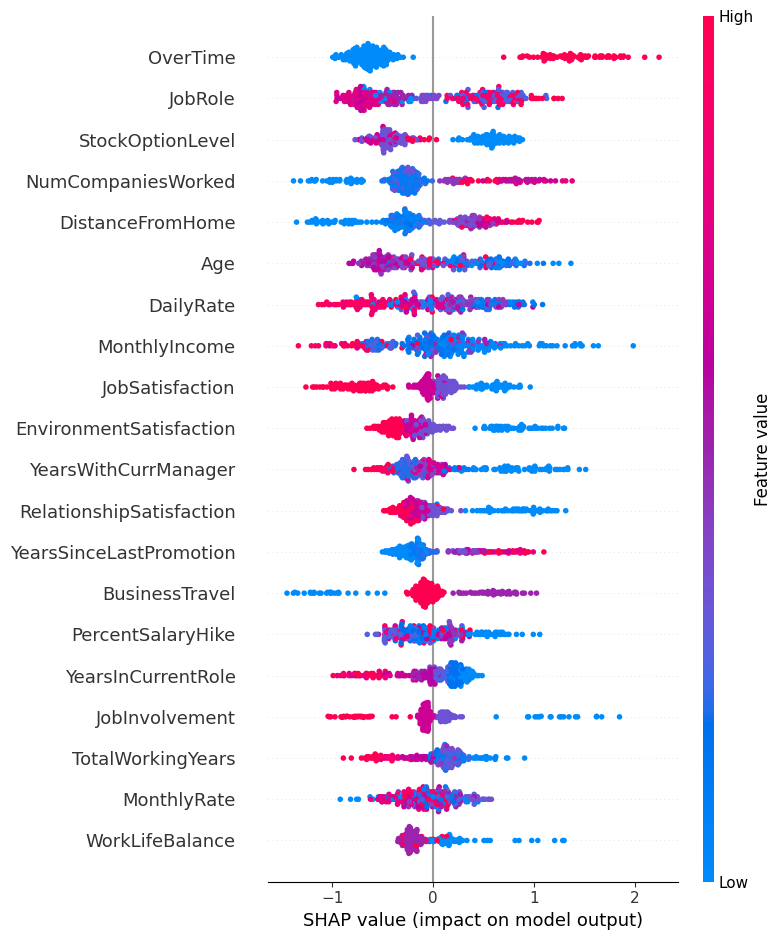

In [11]:
# SHAP explainer 만들기
explainer = shap.Explainer(model, X_train)

# SHAP 값 계산 (검증용 데이터로)
shap_values = explainer(X_test)

# Summary Plot (전체 피처 중요도 + 영향 시각화)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

### SHAP 보는 방법 
* x축: SHAP Value(예측 결과에 얼마나 영향을 줬는가?)
* y축: 피처 이름(중요도 순 정렬)
* 빨간 점: 해당 피처의 값이 크다(High)
* 파란 점: 해당 피처의 값이 작다(Low)
* 오른쪽으로 갈수록: 이직할 확률을 높인 요인
* 왼쪽으로 갈수록: 이직을 낮춘 요인 

### 인사이트 
* OverTime(야근 여부)
빨간 점들이 오른쪽으로 많이 퍼져있음. 야근을 많이 할수록 이직 확률 증가함을 볼 수 있다.
* JobRole, StockOptionLevel, NumCompaniesWorked 등도 영향 있음.
직무, 스톡옵션 수준, 이직 횟수가 예측에 큰 영향을 준다.
* DistanceFromHome
멀리 사는 직원일수록 이직 가능성 높음
* MonthlyIncome
수입이 낮을수록 이직 가능성이 높음(빨간색이 왼쪽)
* JobSatisfaction
만족도 낮으면 이직 가능성이 높음(파란색이 오른쪽으로 퍼짐)
* YearsWithCurrManager
상사와 오래 일한 사람은 이직 가능성이 낮음.

* 진짜 신기했던 점이 근속년수랑은 이직이랑 상관이 없어보인다. 내 주관적인 생각으로는 근속년수가 영향을 미칠거라고 생각했었다. 
SHAP Summary Plot 위치가 낮고, YearsAtCompany가 아래쪽에 있음 → 중요도가 낮음


In [12]:
# 1. RFE로 상위 10개 피처 선택 (기준 모델: 랜덤포레스트)
rfe_model = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=rfe_model, n_features_to_select=10)
X_selected = rfe.fit_transform(X, y)

# 선택된 피처 이름 확인 (선택 사항)
selected_features = X.columns[rfe.support_]
print("선택된 피처:\n", selected_features)

# 2. XGBoost 모델로 학습 및 평가
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_model, X_selected, y, cv=cv, scoring='accuracy')

print(f"\n🎯 XGBoost (선택된 10개 피처) 교차검증 평균 정확도: {scores.mean():.4f}")

선택된 피처:
 Index(['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome',
       'MonthlyRate', 'OverTime', 'PercentSalaryHike', 'TotalWorkingYears',
       'YearsAtCompany'],
      dtype='object')

🎯 XGBoost (선택된 10개 피처) 교차검증 평균 정확도: 0.8388


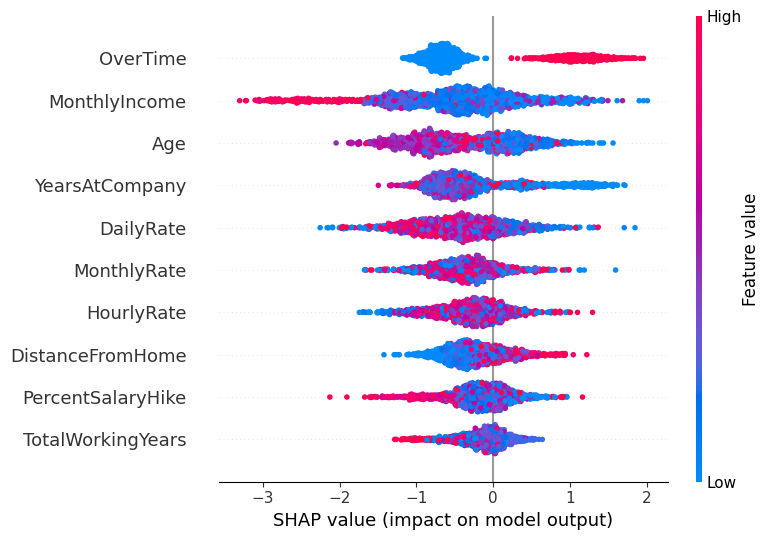

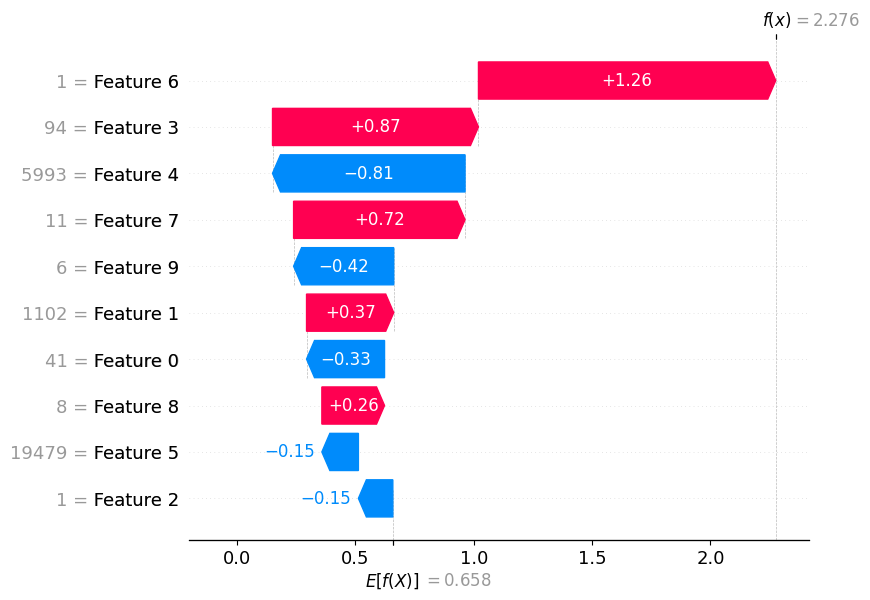

In [13]:
model.fit(X_selected, y)

# 🎯 트리 모델용 explainer 사용
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_selected)

# ✅ 요약 플롯
shap.summary_plot(shap_values, features=X_selected, feature_names=selected_features)

# ✅ 한 샘플 waterfall plot
shap.plots.waterfall(shap_values[0])